<a href="https://colab.research.google.com/github/AjmalSarwary/invest_ml/blob/master/code/cir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulating Interest Rate Changes and Liability Hedging
###Implementing the Cox Ingersoll Ross Model for interest rates

In [1]:
!git clone https://github.com/ajmalsarwary/invest_ml.git
%cd /content/invest_ml
import sys
sys.path.append('/content/invest_ml/code')

Cloning into 'invest_ml'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 276 (delta 27), reused 46 (delta 19), pack-reused 205
Receiving objects: 100% (276/276), 3.06 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/invest_ml


In [2]:
import invest_risk_kit as rk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [4]:
print('Sum: ', liabilities.sum())
rk.pv(liabilities, 0.03)

Sum:  7.0


0    6.23332
dtype: float64

In [5]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return assets/rk.pv(liabilities, r)

In [6]:
funding_ratio(5, liabilities, 0.03)

0    0.802141
dtype: float64

In [7]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets_total, r):
  fr = funding_ratio(assets_total, liabilities, r)

  fr_pct =fr*100
  print(np.round(fr_pct,2))


controls = widgets.interactive(show_funding_ratio,
                              assets_total= widgets.IntSlider(min=1, max=10, step=1, value=5),
                              r = (0, 0.2, 0.01)
                              )
display(controls)

interactive(children=(IntSlider(value=5, description='assets_total', max=10, min=1), FloatSlider(value=0.1, de…

In [8]:
# simulate interest rate paths using the Cox-Ingersoll-Ross model
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    # If the initial rate is not provided, set it equal to the long-term mean rate b.
    if r_0 is None:
        r_0 = b
    # Convert the initial annual rate to an instantaneous rate using a predefined function.
    r_0 = rk.ann_to_inst(r_0)
    # Calculate the time step in years, which is the inverse of the compounding frequency.
    dt = 1/steps_per_year #variance

    # Determine the total number of simulation steps over the given number of years.
    num_steps = int(n_years * steps_per_year) + 1

    # Generate random shocks from a normal distribution, scaled by the square root of dt.
    # This scaling is necessary because the variance of the increments of a Wiener process
    # (used in the CIR model) scales with time, and dt represents a fraction of a year.
    # In the continuous-time version of the model, the variance of the increments of a Wiener process over a time interval is Δt.
    # However, when simulating the model, we work with discrete time steps, which in this case are represented by dt.
    # Here, dt is the length of the time step in years (for example, if we're compounding monthly, dt would be 1/12).

    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))

    # Initialize an array to store the simulated rates, starting with the initial rate.
    rates = np.empty_like(shock)
    rates[0] = r_0

    # Iterate through each time step to simulate the path of interest rates.
    for step in range(1, num_steps):

        # Retrieve the last simulated rate.

        r_t = rates[step-1]

        # Calculate the change in the rate using the CIR model formula.
        # The mean-reversion term a*(b-r_t)*dt pulls the rate towards the long-term mean b
        # at a speed determined by a. The mean-reversion effect is stronger when the rate is
        # further away from b (the correction applied to bring r_t back towards b is more significant).
        # The product a*(b − r_t) determines the drift of the interest rate at each point in time, pulling it towards the long-term mean b.
        # The term dt scales this effect to the length of the time step.

        d_r_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[step]

        # Update the rate with the change. The function np.sqrt(r_t) ensures that the rate
        # stays non-negative since the square root of a negative number is not defined.
        # The shock term introduces randomness and is scaled by both the volatility sigma
        # and the square root of the current rate r_t, reflecting the CIR model's
        # characteristic that volatility increases with the level of the rate.

        rates[step] = abs(r_t + d_r_t)

    # Convert the simulated instantaneous rates back to annual rates and return as a DataFrame.
    return pd.DataFrame(data=rk.inst_to_ann(rates), index=range(num_steps))



<Axes: >

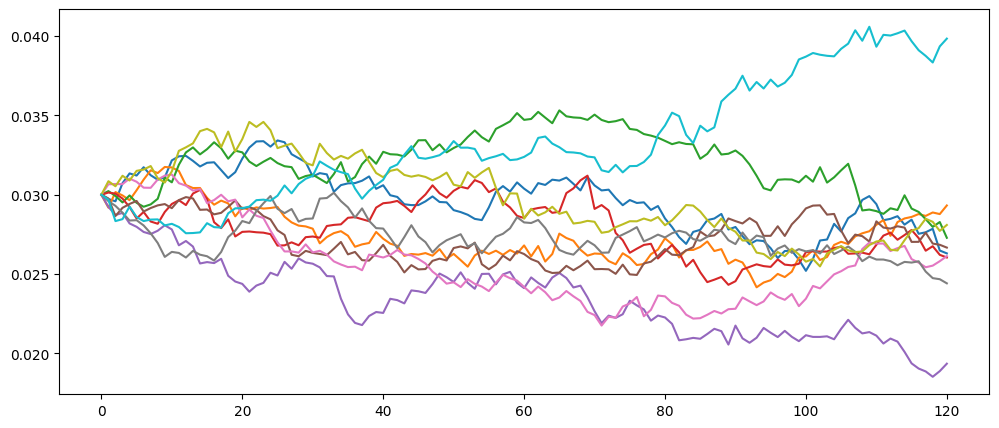

In [9]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [10]:
def show_cir(r_0=0.03, a=0.9, b=0.08, sigma=0.05, n_scenarios=5):
  '''
  '''
  ax = cir(n_scenarios=n_scenarios,a=a,b=b, sigma=sigma, r_0=r_0).plot(figsize=(12,5),ls=":",
                                                                       legend=False,
                                                                       title="CIR interest rate risk evolution for interest rate-sensitive instruments")
  ax.axhline(y=b, ls=":", color="black")
  plt.show()

In [11]:
import ipywidgets as widgets
from IPython.display import display

cir_controls = widgets.interactive(show_cir,
                                   r_0=(0, .15, .01),
                                    a=(0, 1, .1),
                                   b=(0, .15, .01),
                                   sigma=(0, .1, .01),
                                   n_scenarios=(1,100)
                                  )

display(cir_controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.9, …

###Generating the random price evolution of a Zero-Coupon Bond

In [59]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = rk.ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float

    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####

    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=rk.inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

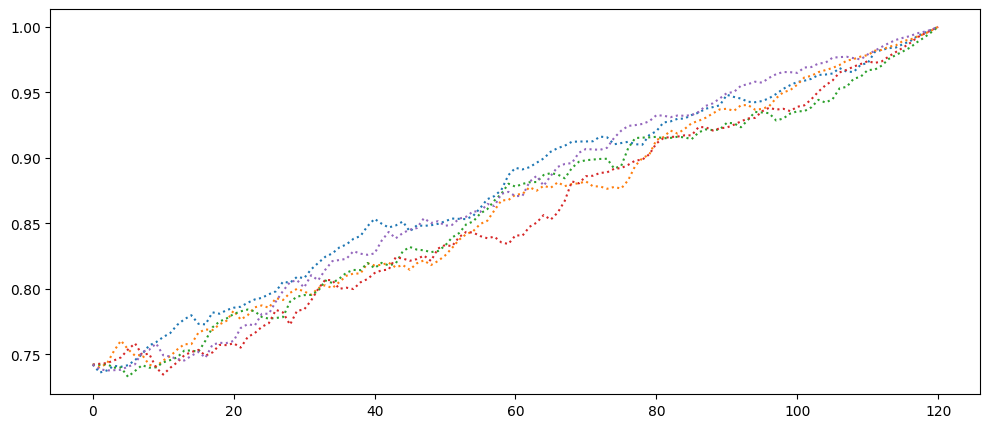

In [28]:
import ipywidgets as widgets
from IPython.display import display

def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False,ls=":", figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

In [40]:
import math
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = rk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

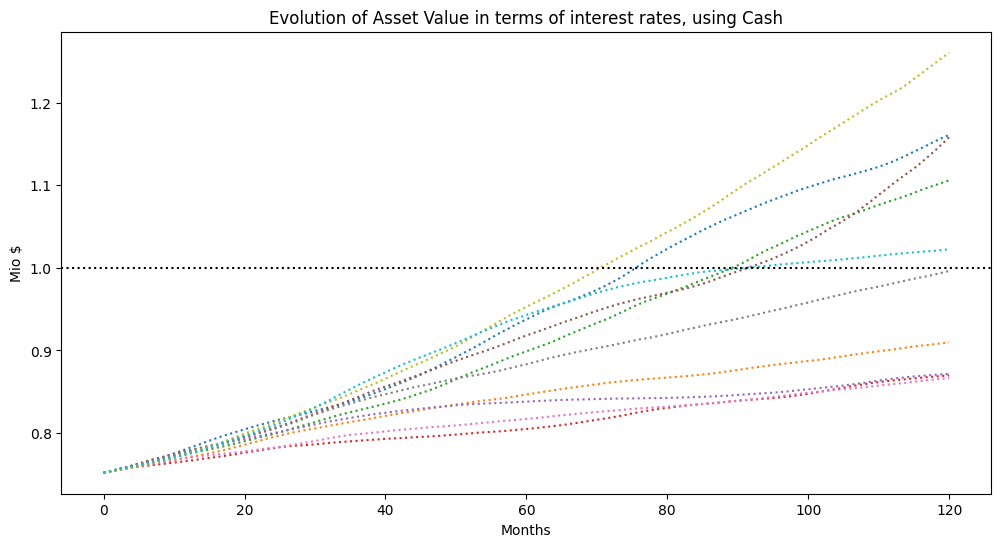

In [45]:
ax = av_cash.plot(legend=False, figsize=(12,6), title="Evolution of Asset Value in terms of interest rates, using Cash",ls=":", ylabel="Mio $", xlabel="Months")
ax.axhline(y=1, ls=":", color="black")
plt.show()

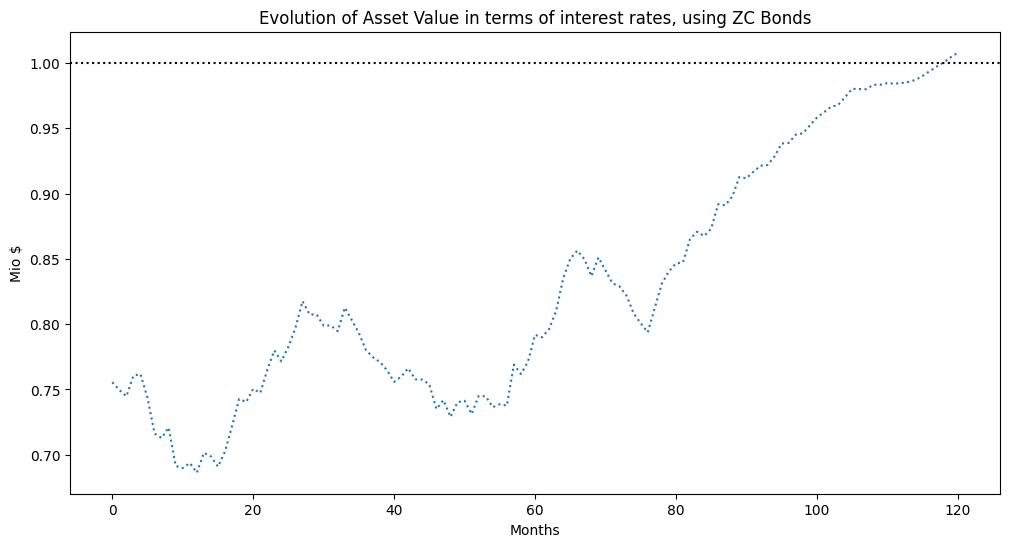

In [46]:
ax = av_zc_bonds.plot(legend=False, figsize=(12,6), title="Evolution of Asset Value in terms of interest rates, using ZC Bonds",ls=":", ylabel="Mio $", xlabel="Months")
ax.axhline(y=1, ls=":", color="black")
plt.show()

<Axes: title={'center': 'Returns using Cash (10 scenarios)'}>

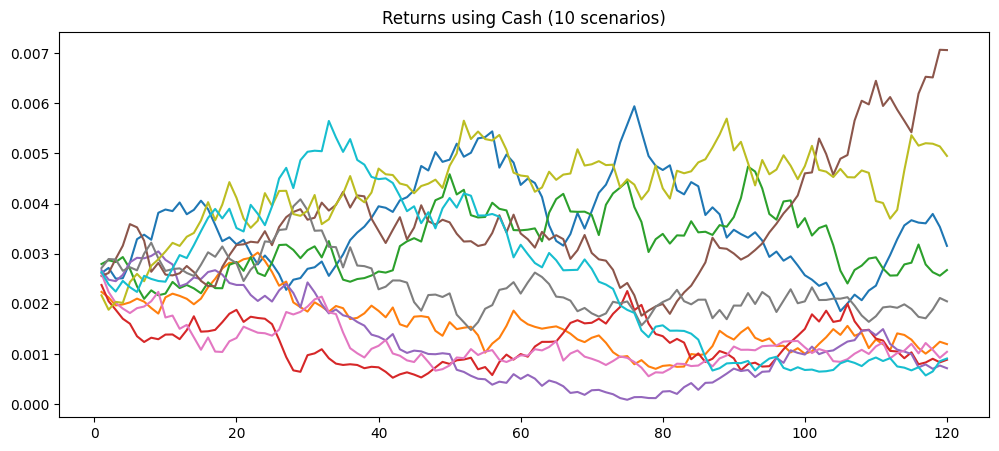

In [47]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns using ZC Bonds (10 scenarios)'}>

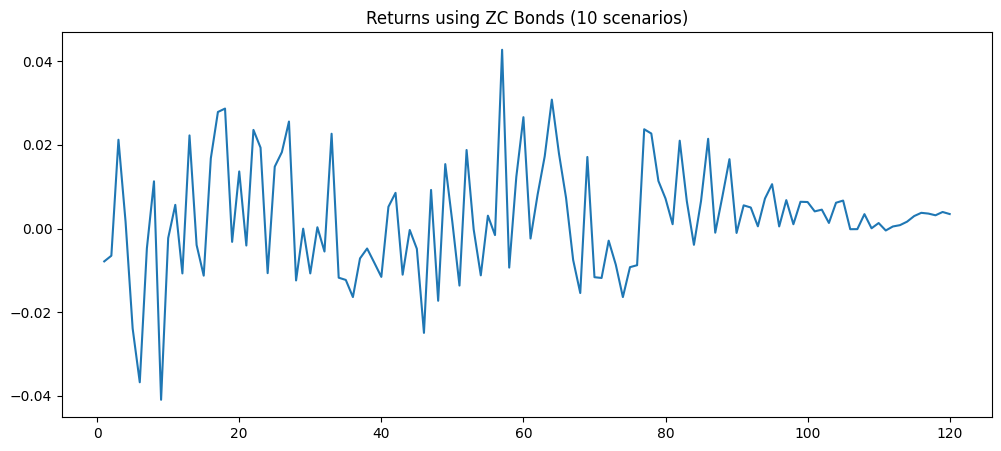

In [48]:
av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns of Funding Ratio with Cash (10 scenarios)'}>

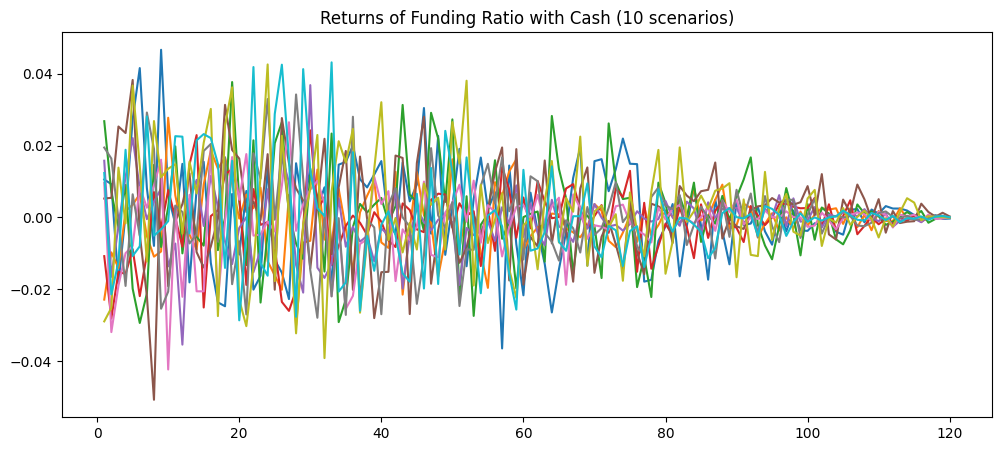

In [49]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Returns of Funding Ratio with ZC Bonds (10 scenarios)'}>

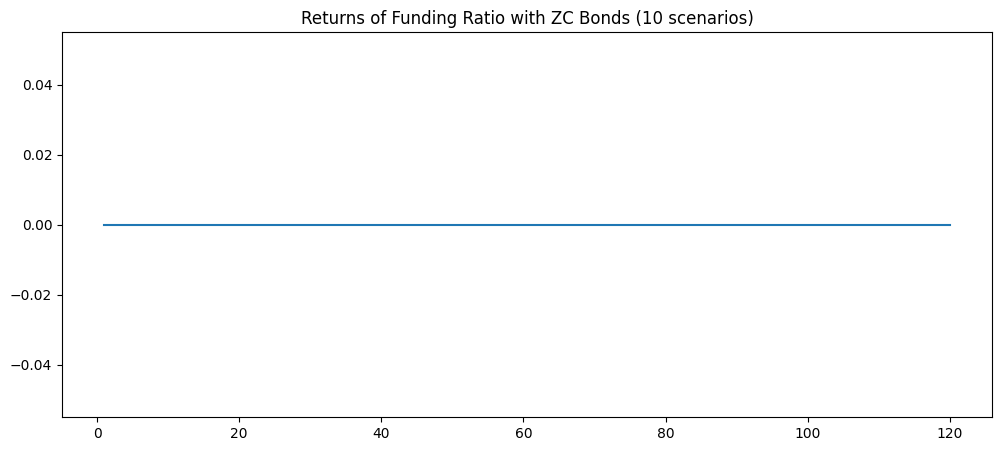

In [50]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Asset Values using ZC Bonds (10 scenarios)'}>

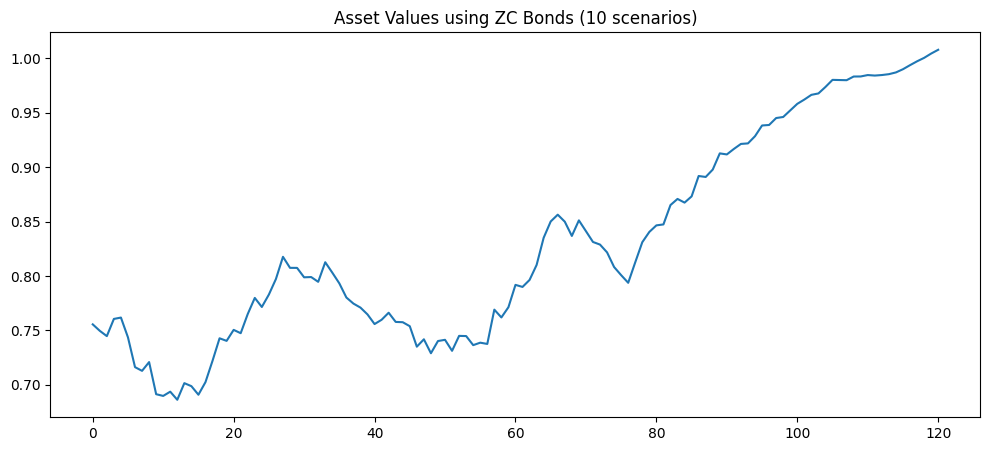

In [51]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Funding Ratio with Cash (10 scenarios)'}>

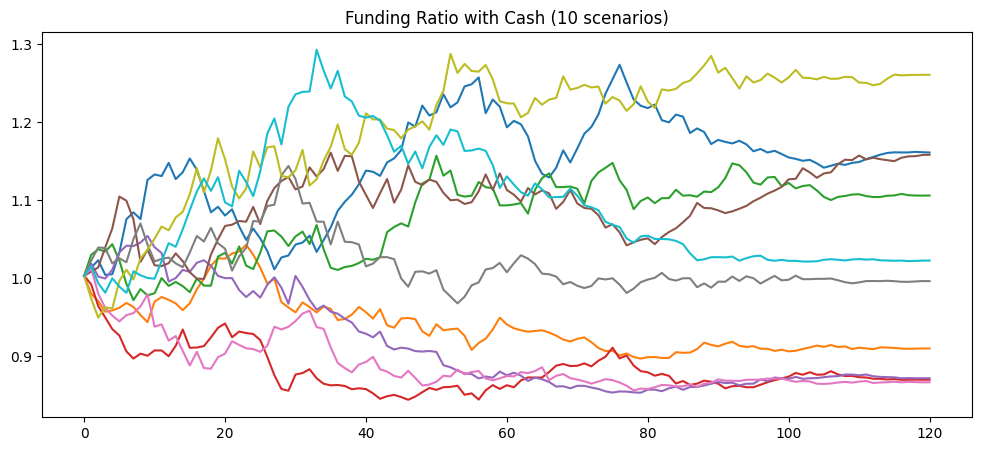

In [52]:
(av_cash/liabilities).plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<Axes: title={'center': 'Funding Ratio with ZC Bonds (10 scenarios)'}>

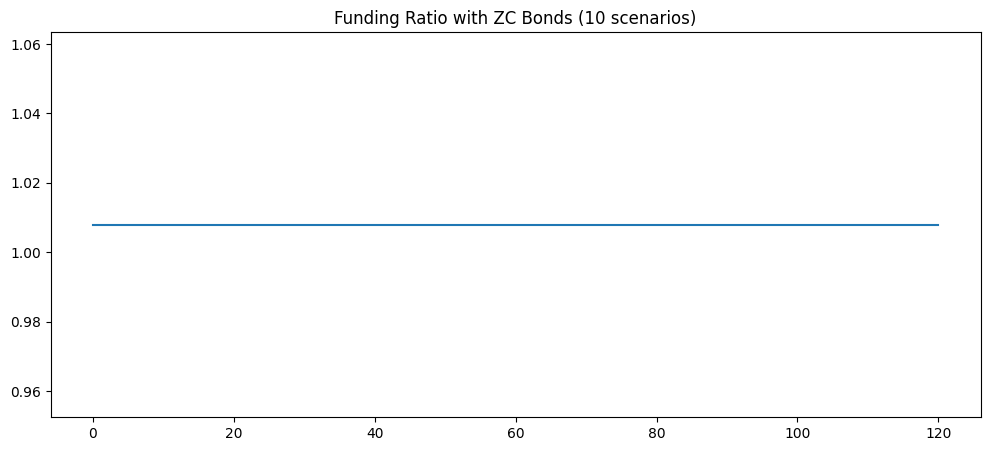

In [53]:
(av_zc_bonds/liabilities).plot(title='Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))


###Terminal Funding Ratios

In [63]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = rk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

<Axes: >

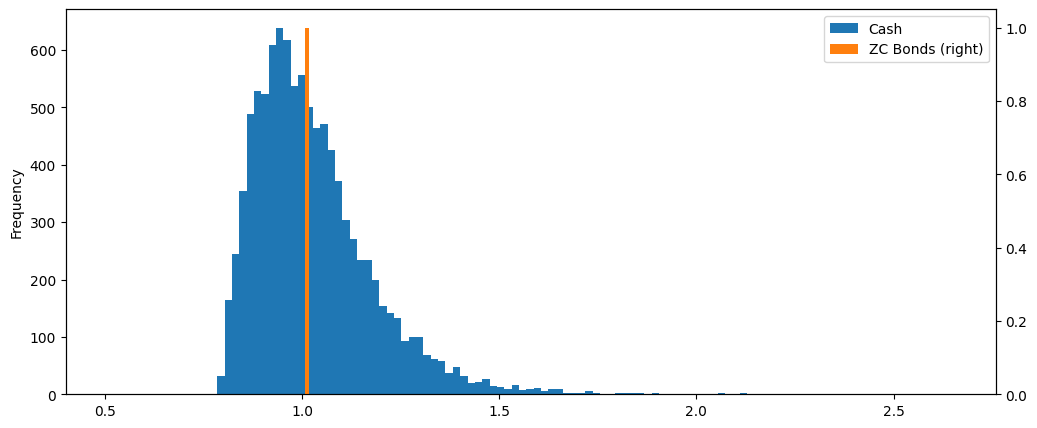

In [64]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)